# 自訂 Callback 記錄每個批次的損失

## 建立模型

In [1]:
import tensorflow as tf
import pandas as pd

# 匯入 MNIST 手寫阿拉伯數字 訓練資料
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()


# 訓練/測試資料的 X/y 維度
x_train.shape, y_train.shape,x_test.shape, y_test.shape

# 特徵縮放，使用常態化(Normalization)，公式 = (x - min) / (max - min)
# 顏色範圍：0~255，所以，公式簡化為 x / 255
# 注意，顏色0為白色，與RGB顏色不同，(0,0,0) 為黑色。
x_train_norm, x_test_norm = x_train / 255.0, x_test / 255.0

In [2]:
# 建立模型
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [3]:
# 設定優化器(optimizer)、損失函數(loss)、效能衡量指標(metrics)的類別
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [4]:
y_train_one_hot_encoding = tf.keras.utils.to_categorical(y_train)

## 自訂 Callback

In [8]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.task_type=''
        self.epoch=0
        self.batch=0
        self.df = None # pd.DataFrame(columns=['epoch', 'batch', 'metrics'])
        
    def on_train_begin(self, logs=None):
        self.task_type='訓練'
        print("訓練開始...")

    def on_train_end(self, logs=None):
        print(self.df.shape)
        print("訓練結束.")

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch=epoch

    def on_train_batch_end(self, batch, logs=None):
        df2 = pd.DataFrame([[self.epoch, batch, logs["loss"]]], columns=['epoch', 'batch', 'metrics'])
        if self.df is None:
            self.df = df2
        else:
            self.df = pd.concat([self.df, df2], ignore_index=True)
            
    def save(self, file_name):
        self.df.to_excel(file_name)

## 自訂Callback及訓練模型

In [9]:
custom_callback = CustomCallback()
model.fit(x_train_norm, y_train_one_hot_encoding, epochs=15, batch_size=256, verbose=0, 
          validation_split=0.2, callbacks=[custom_callback])

訓練開始...
(2820, 3)
訓練結束.


## 訓練過程存檔

In [10]:
custom_callback.save('./custom_callback.xlsx')

In [12]:
df = custom_callback.df
df.head()

,epoch,batch,metrics
0,0,0,0.002678
1,0,1,0.003025
2,0,2,0.002692
3,0,3,0.002456
4,0,4,0.002442


## 繪圖

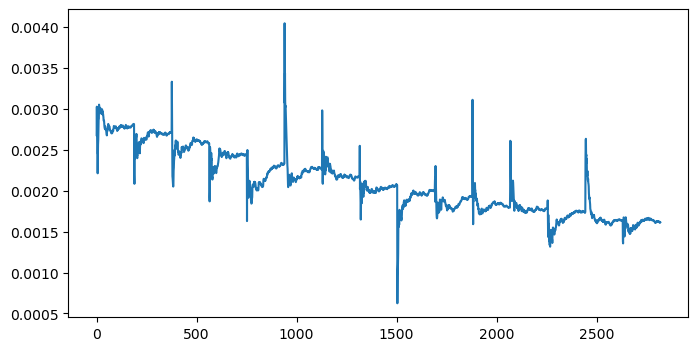

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(df.metrics);

## 依執行週期(epoch)作小計

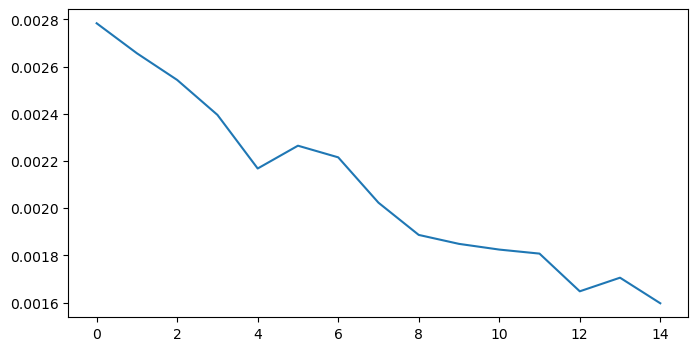

In [24]:
df2 = df.groupby(by='epoch').mean()
plt.figure(figsize=(8, 4))
plt.plot(df2.index, df2.metrics);